In [1]:
!pip install opendatasets

In [3]:
import opendatasets  as od
od.download("https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: boubacarpotyly
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset


100%|██████████| 1.01M/1.01M [00:00<00:00, 701MB/s]

In [4]:
import pandas as pd
df = pd.read_csv("/content/hate-speech-and-offensive-language-dataset/labeled_data.csv")

In [5]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
df.drop(columns=["Unnamed: 0"],inplace=True)

In [7]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

In [8]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [25]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

#Préparation des données (on garde le nettoyage simple)
def clean(t):
    t = t.lower()
    t = re.sub(r'@[A-Za-z0-9_]+|https?://\S+|[^a-z\s]', '', t)
    return t

df['clean_tweet'] = df['tweet'].apply(clean)

##### Vectorisation

In [26]:

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(df['clean_tweet'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### La boucle de Benchmark

In [28]:

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(objective='multi:softprob', num_class=3)
}

results = []
best_f1 = 0
best_model_name = ""

print(f"{'Modèle':<20} | {'F1-Score Macro':<15} | {'Recall Classe 0':<15}")
print("-" * 55)

for name, model in models.items():
    # Entraînement
    model.fit(X_train, y_train)
    # Prédiction
    y_pred = model.predict(X_test)

    # Métriques
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    recall_0 = report['0']['recall']

    results.append({"Model": name, "F1_Macro": f1_macro, "Recall_0": recall_0})
    print(f"{name:<20} | {f1_macro:<15.4f} | {recall_0:<15.4f}")

    # Sauvegarde du meilleur modèle
    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_model_name = name
        best_model_obj = model

print("-" * 55)
print(f"Le meilleur modèle est : {best_model_name} avec un F1 de {best_f1:.4f}")

Modèle               | F1-Score Macro  | Recall Classe 0
-------------------------------------------------------
Logistic Regression  | 0.7083          | 0.6329         
Random Forest        | 0.7001          | 0.2203         
Naive Bayes          | 0.5446          | 0.0280         
XGBoost              | 0.7049          | 0.2133         
-------------------------------------------------------
Le meilleur modèle est : Logistic Regression avec un F1 de 0.7083


#####
# Définition de la grille de recherche

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

###### On optimise spécifiquement pour le F1-Score Macro

In [30]:

grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score F1 : {grid_search.best_score_:.4f}")

Meilleurs paramètres : {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur score F1 : 0.7395


### Évaluation finale sur le test set

In [31]:
#
best_lr = grid_search.best_estimator_
y_pred_final = best_lr.predict(X_test)
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       286
           1       0.95      0.92      0.93      3838
           2       0.80      0.92      0.86       833

    accuracy                           0.89      4957
   macro avg       0.73      0.77      0.75      4957
weighted avg       0.90      0.89      0.89      4957



In [32]:
!pip install tensorflow

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from sklearn.utils import class_weight
import numpy as np

# Paramètres
max_words = 10000
max_len = 50
embedding_dim = 128

#####  Préparation des séquences

In [34]:

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df['clean_tweet'])

X_seq = tokenizer.texts_to_sequences(df['clean_tweet'])
X_pad = pad_sequences(X_seq, maxlen=max_len)
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
# 3. Calcul des poids pour gérer le déséquilibre dans Keras
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(weights))

##### Architecture du modèle

In [36]:

model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    SpatialDropout1D(0.3),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


##### Entraînement

In [37]:

print("Entraînement du LSTM en cours...")
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights_dict,
    verbose=1
)

Entraînement du LSTM en cours...
Epoch 1/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 113s 182ms/step - accuracy: 0.6778 - loss: 0.9086 - val_accuracy: 0.8507 - val_loss: 0.4977
Epoch 2/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 98s 176ms/step - accuracy: 0.8408 - loss: 0.4641 - val_accuracy: 0.8548 - val_loss: 0.3754
Epoch 3/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 97s 175ms/step - accuracy: 0.8660 - loss: 0.3115 - val_accuracy: 0.8245 - val_loss: 0.4565
Epoch 4/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 97s 174ms/step - accuracy: 0.8823 - loss: 0.2601 - val_accuracy: 0.7877 - val_loss: 0.5494
Epoch 5/5
558/558 ━━━━━━━━━━━━━━━━━━━━ 96s 172ms/step - accuracy: 0.8900 - loss: 0.2087 - val_accuracy: 0.8694 - val_loss: 0.4060


#### Évaluation

In [38]:

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n--- Rapport de Classification (Deep Learning - LSTM) ---")

155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step

--- Rapport de Classification (Deep Learning - LSTM) ---
              precision    recall  f1-score   support

           0       0.31      0.49      0.38       286
           1       0.95      0.88      0.91      3838
           2       0.76      0.89      0.82       833

    accuracy                           0.86      4957
   macro avg       0.67      0.75      0.70      4957
weighted avg       0.88      0.86      0.87      4957



In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calcul de la matrice
cm = confusion_matrix(y_test, y_pred)

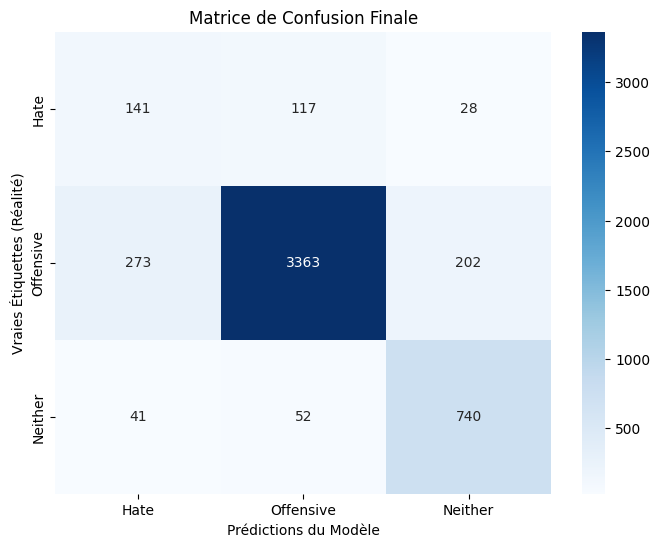

In [40]:
# 2. Préparation du graphique
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate', 'Offensive', 'Neither'],
            yticklabels=['Hate', 'Offensive', 'Neither'])

plt.xlabel('Prédictions du Modèle')
plt.ylabel('Vraies Étiquettes (Réalité)')
plt.title('Matrice de Confusion Finale')
plt.show()

In [42]:
import joblib

joblib.dump(best_lr, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [43]:

joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Modèles ML sauvegardés avec succès !")

Modèles ML sauvegardés avec succès !


In [44]:

model.save('lstm_hate_speech_model.h5')


import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Modèles DL sauvegardés avec succès !")

Modèles DL sauvegardés avec succès !
